# Introducción
Este cuaderno fue desarrollado por el **Laboratorio de Estructura Molecular y Propiedades (LEMyP)** donde desarrollamos el proyecto **MammoInsight**.

### Objetivo:
Explorar de forma práctica cómo una red neuronal convolucional (CNN) puede analizar imágenes ecograficas mamarias (benignas y malignas) y clasificarlas utilizando técnicas modernas de aprendizaje profundo.


### Instituciones:
- **LEMyP - Instituto de Química Básica y Aplicada del Nordeste Argentino (IQUIBA-NEA)**    
- **MammoInsight.org** – [https://www.mammoinsight.org](https://www.mammoinsight.org)


# 🐍 Introducción técnica: ¿Qué es Python y qué usamos en este cuaderno?

### ¿Qué es Python?
**Python** es un lenguaje de programación simple, poderoso y ampliamente utilizado en ciencia de datos, inteligencia artificial, bioinformática y desarrollo web.
Documentación oficial: https://docs.python.org/es/3/

---

### Librerías utilizadas en este proyecto

- **PyTorch**: Biblioteca de aprendizaje profundo para construir y entrenar redes neuronales  
   https://pytorch.org/

- **torchvision**: Utilidades específicas para trabajar con imágenes (datasets, transformaciones, modelos preentrenados como ResNet)  
   https://pytorch.org/vision/stable/

- **matplotlib** y **seaborn**: Para graficar resultados y métricas  
   https://matplotlib.org/  
   https://seaborn.pydata.org/

- **PIL (Pillow)**: Manipulación de imágenes (abrir, redimensionar, visualizar)  
   https://pillow.readthedocs.io/

- **sklearn (Scikit-learn)**: Métricas de evaluación como precisión, F1 score, matriz de confusión  
   https://scikit-learn.org/stable/

In [1]:
#@title Paso 1: Descarga del dataset desde Kaggle
!curl -L -o breast-ultrasound-images-dataset.zip https://www.kaggle.com/api/v1/datasets/download/aryashah2k/breast-ultrasound-images-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  194M  100  194M    0     0   115M      0  0:00:01  0:00:01 --:--:--  182M


## Paso 2: ¿Qué hace este bloque?

— Descomprime el dataset  

— Busca imágenes

— Muestra ejemplos
   
— Cuenta casos por clase

Dataset descomprimido.
 Carpeta detectada:  Dataset_BUSI_with_GT


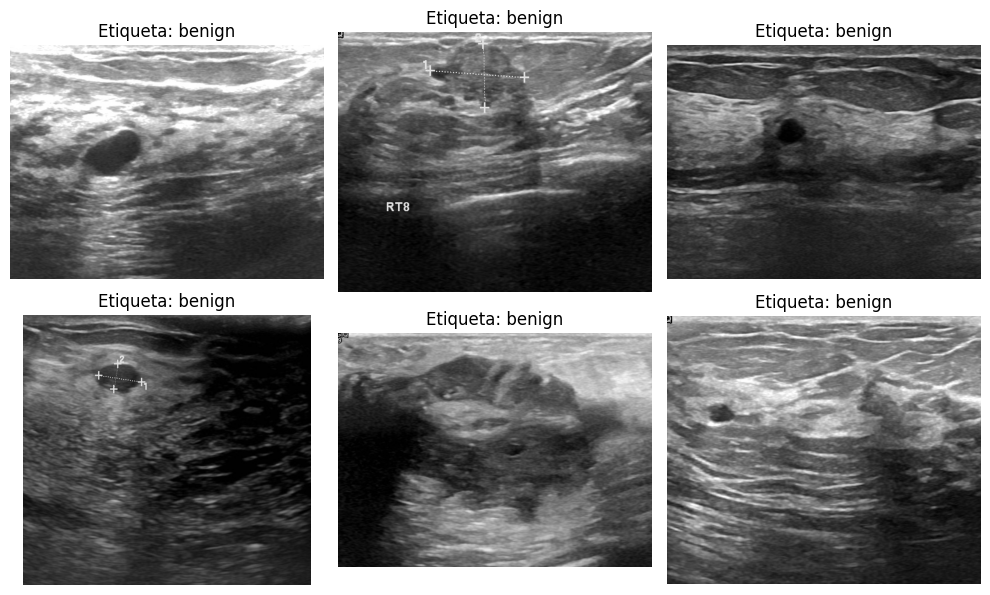

Total de imágenes por clase (sin máscaras):
benign : 437 imágenes
malignant : 210 imágenes


In [2]:
#@title Paso 2: Exploramos un poco los datos que tenemos

import os, zipfile
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

#  Paso 1: Descomprimir si no se ha hecho
zip_path = "breast-ultrasound-images-dataset.zip"
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Dataset descomprimido.")
else:
    print("No se encontró el archivo ZIP.")

# Paso 2: Buscar carpeta correcta
root_folder = next(f for f in os.listdir() if "BUSI" in f and os.path.isdir(f))
print(" Carpeta detectada: ", root_folder)

# Paso 3: Cargar imágenes (sin máscaras)
clases = ['benign', 'malignant']
imagenes = []
for clase in clases:
    clase_path = os.path.join(root_folder, clase)
    if os.path.exists(clase_path):
        for img in os.listdir(clase_path):
            if "_mask" not in img.lower():
                imagenes.append((os.path.join(clase_path, img), clase))

# Mostrar 6 imágenes con etiquetas
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axs.flatten()):
    img_path, etiqueta = imagenes[i]
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Etiqueta: {etiqueta}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Paso 4: Contar imágenes por clase
conteo = Counter([et for _, et in imagenes])
print("Total de imágenes por clase (sin máscaras):")
for clase, cantidad in conteo.items():
    print(clase, ":", cantidad ,"imágenes")


## Paso 3: ¿Qué hace este bloque?

— Carga imágenes limpias  
— Aplica preprocesamiento  
— Divide en 3 grupos  
— Deja listo para entrenar


In [3]:
#@title Paso 3: Cargar y preparar los datos

# Librerías necesarias para IA, imágenes y métricas
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuración básica
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE, EPOCHS = 32, 15
print(" Usando dispositivo:", DEVICE)

# Transformaciones de imágenes para entrenar
# Aumentan la diversidad visual de las imágenes, ayudando a evitar el sobreajuste.
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),               # Redimensionar todas las imágenes al mismo tamaño
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Recortar aleatoriamente zonas (simula zooms)
    transforms.RandomHorizontalFlip(p=0.5),      # Voltear horizontalmente con 50% de probabilidad
    transforms.RandomRotation(15),               # Rotar ligeramente para variar orientación
    transforms.ColorJitter(                      # Cambiar brillo y contraste (simula diferentes equipos)
        brightness=0.2,
        contrast=0.2,
        saturation=0.1
    ),
    transforms.ToTensor(),                       # Convertir a tensor para PyTorch
    transforms.Normalize(                        # Normalizar valores RGB (ajuste estándar de ResNet)
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


# Transformación para validación/test (sin aumentos)
# Solo se reescala y normaliza, para medir el rendimiento real del modelo.
val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# Cargar solo imágenes SIN máscaras
def is_not_mask(p): return "_mask" not in os.path.basename(p)
dataset_raw = datasets.ImageFolder('Dataset_BUSI_with_GT', is_valid_file=is_not_mask)

#print(" Total de imágenes cargadas (sin máscaras):", len(dataset_raw))

#  Quedarse solo con clases benign y malignant
targets = ['benign', 'malignant']
indices = [i for i, (p, y) in enumerate(dataset_raw.samples) if dataset_raw.classes[y] in targets]
binary_subset = Subset(dataset_raw, indices)
print(" Total de imágenes benign/malign:", len(binary_subset))

# Clase personalizada para limpiar y transformar
class CleanDataset(Dataset):
    def __init__(self, subset, tf):
        self.s = subset
        self.t = tf
        self.map = {i: j for j, c in enumerate(targets) for i, cls in enumerate(dataset_raw.classes) if cls == c}
    def __getitem__(self, i):
        x, y = self.s[i]
        return self.t(x), self.map[y]
    def __len__(self): return len(self.s)

# Dividir en train / val / test
n = len(binary_subset)
n_train, n_val = int(0.7 * n), int(0.15 * n)
train_s, val_s, test_s = random_split(binary_subset, [n_train, n_val, n - n_train - n_val])
train_ds, val_ds, test_ds = CleanDataset(train_s, train_tf), CleanDataset(val_s, val_tf), CleanDataset(test_s, val_tf)

# Cargar en DataLoaders para entrenamiento
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Confirmaciones finales
print(" Tamaño del conjunto de entrenamiento:", len(train_ds))
print(" Tamaño del conjunto de validación:", len(val_ds))
print(" Tamaño del conjunto de prueba:", len(test_ds))
print(" Preparación de datos completada.")


 Usando dispositivo: cuda
 Total de imágenes benign/malign: 647
 Tamaño del conjunto de entrenamiento: 452
 Tamaño del conjunto de validación: 97
 Tamaño del conjunto de prueba: 98
 Preparación de datos completada.


## Paso 4: ¿Qué hace este bloque?

— Carga modelo ResNet  
— Ajusta para binario  
— Entrena por épocas  
— Mide precisión y pérdida

In [4]:
#@title Paso 4: Entrenar la red neuronal (ResNet18)

# Entrenar la red neuronal (ResNet18 con visualización clara)

from torch import nn
from tqdm import tqdm  # Barra de progreso elegante

# Cargar el modelo preentrenado (ResNet18)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Añadir Dropout para mejorar generalización
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(model.fc.in_features, 1)
)

# Enviar a GPU o CPU
model = model.to(DEVICE)

# Optimizador con weight decay (evita sobreajuste)
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

history = {'train': [], 'val': [], 'acc': []}

print(" Comenzando entrenamiento...\n")

for e in range(EPOCHS):
    model.train()
    tloss = 0
    loop = tqdm(train_loader, desc=" Época " + str(e+1), leave=False)

    # --- Entrenamiento ---
    for X, y in loop:
        X = X.to(DEVICE)
        y = y.float().unsqueeze(1).to(DEVICE)

        opt.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()

        tloss += loss.item() * X.size(0)

    # --- Validación ---
    model.eval()
    vloss, correct, total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(DEVICE)
            y = y.float().unsqueeze(1).to(DEVICE)
            out = model(X)
            vloss += loss_fn(out, y).item() * X.size(0)
            pred = (torch.sigmoid(out) > 0.5).float()
            correct += (pred == y).sum().item()
            total += y.size(0)

    train_loss = tloss / len(train_loader.dataset)
    val_loss = vloss / len(val_loader.dataset)
    acc = 100 * correct / total

    history['train'].append(train_loss)
    history['val'].append(val_loss)
    history['acc'].append(acc)

    # Colores sobrios: verde (mejor), rojo (peor), blanco (neutral)
    if acc >= 85:
        color = "\033[92m"  # Verde: buena precisión
    elif val_loss > train_loss * 1.2:
        color = "\033[91m"  # Rojo: posible sobreajuste
    else:
        color = "\033[0m"   # Blanco: neutral

    reset = "\033[0m"

    print(color + " Época:", e + 1,
          "| Pérdida entrenamiento:", round(train_loss, 4),
          "| Pérdida validación:", round(val_loss, 4),
          "| Precisión:", round(acc, 2), "%", reset)

print("\n Entrenamiento finalizado con éxito.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


 Comenzando entrenamiento...



 Época: 1 | Pérdida entrenamiento: 0.5653 | Pérdida validación: 0.4782 | Precisión: 77.32 % 


 Época: 2 | Pérdida entrenamiento: 0.3529 | Pérdida validación: 0.3983 | Precisión: 84.54 % 


 Época: 3 | Pérdida entrenamiento: 0.2829 | Pérdida validación: 0.37 | Precisión: 87.63 % 


 Época: 4 | Pérdida entrenamiento: 0.2265 | Pérdida validación: 0.4137 | Precisión: 80.41 % 


 Época: 5 | Pérdida entrenamiento: 0.2096 | Pérdida validación: 0.3905 | Precisión: 84.54 % 


 Época: 6 | Pérdida entrenamiento: 0.1741 | Pérdida validación: 0.3465 | Precisión: 86.6 % 


 Época: 7 | Pérdida entrenamiento: 0.1562 | Pérdida validación: 0.3325 | Precisión: 85.57 % 


 Época: 8 | Pérdida entrenamiento: 0.1184 | Pérdida validación: 0.321 | Precisión: 89.69 % 


 Época: 9 | Pérdida entrenamiento: 0.1356 | Pérdida validación: 0.3526 | Precisión: 87.63 % 


 Época: 10 | Pérdida entrenamiento: 0.0911 | Pérdida validación: 0.4165 | Precisión: 84.54 % 


 Época: 11 | Pérdida entrenamiento: 0.093 | Pérdida validación: 0.4436 | Precisión: 89.69 % 


 Época: 12 | Pérdida entrenamiento: 0.0998 | Pérdida validación: 0.2716 | Precisión: 89.69 % 


 Época: 13 | Pérdida entrenamiento: 0.0881 | Pérdida validación: 0.2561 | Precisión: 91.75 % 


 Época: 14 | Pérdida entrenamiento: 0.1012 | Pérdida validación: 0.3313 | Precisión: 91.75 % 


 Época: 15 | Pérdida entrenamiento: 0.0715 | Pérdida validación: 0.3082 | Precisión: 89.69 % 

 Entrenamiento finalizado con éxito.


## Paso 5: ¿Qué hace este bloque?

— Muestra gráficas del entrenamiento  
— Evalúa el modelo final  
— Muestra matriz de confusión  
— Imprime precisión y métricas


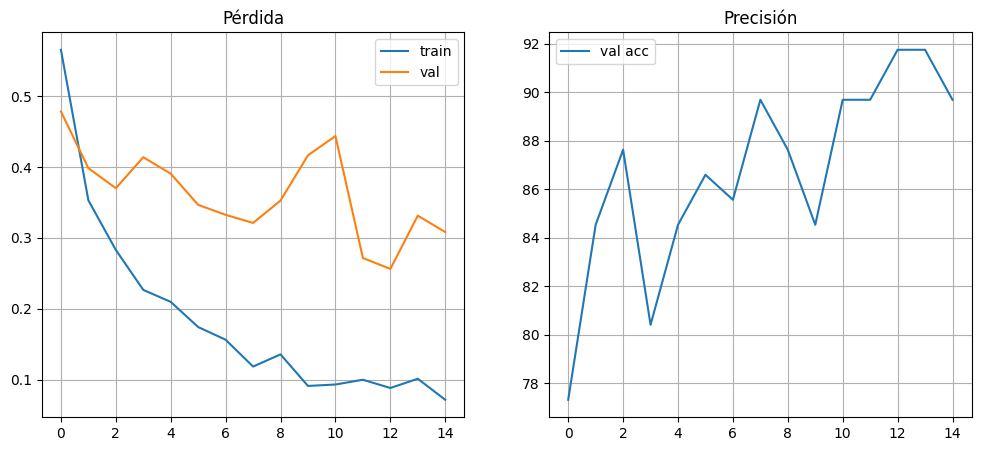

 Se mostraron las curvas de entrenamiento.


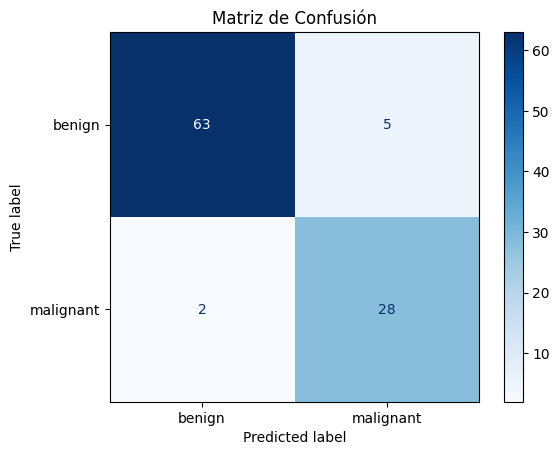

 Informe de clasificación:
              precision    recall  f1-score   support

      benign       0.97      0.93      0.95        68
   malignant       0.85      0.93      0.89        30

    accuracy                           0.93        98
   macro avg       0.91      0.93      0.92        98
weighted avg       0.93      0.93      0.93        98



In [5]:
#@title Paso 5: Mostrar curvas de entrenamiento

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

#  Curva de pérdida (error)
plt.subplot(1,2,1)
plt.plot(history['train'], label='train')
plt.plot(history['val'], label='val')
plt.title("Pérdida")
plt.grid()
plt.legend()

# Curva de precisión (% aciertos)
plt.subplot(1,2,2)
plt.plot(history['acc'], label='val acc')
plt.title("Precisión")
plt.grid()
plt.legend()
plt.show()

print(" Se mostraron las curvas de entrenamiento.")

# Paso 5️ - Evaluar el modelo en el conjunto de prueba (test)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

model.eval()
Y_true, Y_pred = [], []

#  Realizar predicciones sobre datos de prueba
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        out = model(X)
        pred = (torch.sigmoid(out) > 0.5).cpu().numpy().flatten()
        Y_pred.extend(pred)
        Y_true.extend(y.numpy())

# Mostrar matriz de confusión
cm = confusion_matrix(Y_true, Y_pred)
ConfusionMatrixDisplay(cm, display_labels=targets).plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# Imprimir reporte con métricas
print(" Informe de clasificación:")
print(classification_report(Y_true, Y_pred, target_names=targets))

##  Paso 6: ¿Qué hace este bloque?

— Toma imágenes reales del test  
— Predice con la IA entrenada  
— Compara real vs predicho  
— Muestra 5 resultados visuales


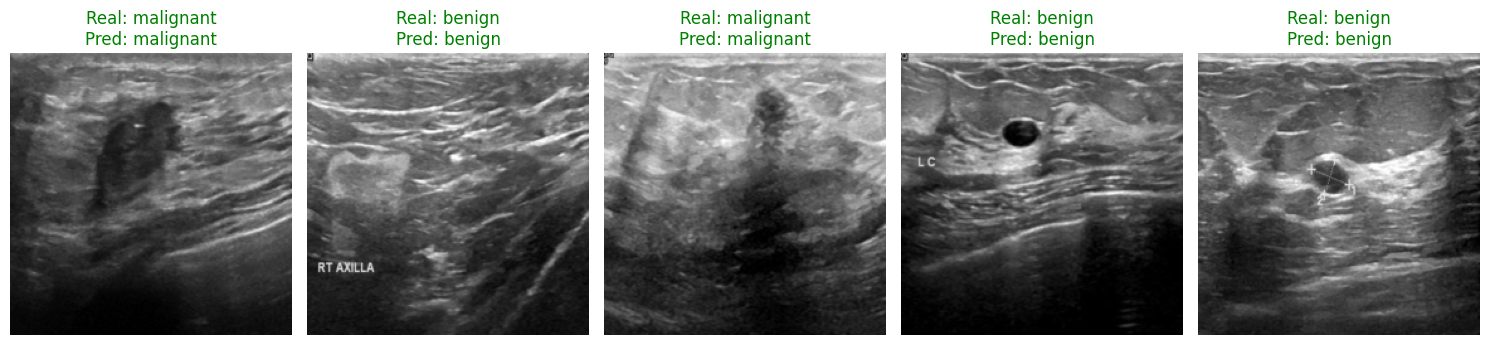

 Mostrando 5 predicciones aleatorias del modelo.


In [6]:
#@title Paso 6️- Mostrar 5 predicciones aleatorias del test set

import random
from torchvision.transforms.functional import to_pil_image

# Elegir 5 índices aleatorios del conjunto de prueba
random_indices = random.sample(range(len(test_ds)), 5)

# Obtener imágenes y etiquetas reales
imagenes = [test_ds[i][0] for i in random_indices]
etiquetas = [test_ds[i][1] for i in random_indices]

# Preparar batch manual para pasar al modelo
X_batch = torch.stack(imagenes).to(DEVICE)

# Predecir sin entrenamiento
with torch.no_grad():
    pred = (torch.sigmoid(model(X_batch)) > 0.5).cpu()

# Mostrar imágenes y predicciones
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    img = imagenes[i].permute(1, 2, 0).numpy()
    img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)
    axs[i].imshow(img)
    axs[i].axis('off')
    real = targets[etiquetas[i]]
    predicho = targets[int(pred[i])]
    color = 'green' if real == predicho else 'red'
    axs[i].set_title("Real: " + real + "\nPred: " + predicho, color=color)

plt.tight_layout()
plt.show()

print(" Mostrando 5 predicciones aleatorias del modelo.")



###  Contacto y colaboración

Si deseas continuar explorando estas herramientas, implementar IA en tu área médica o realizar proyectos colaborativos, puedes contactarnos:

**mammoinsightdevelops@mammoinsight.org**  
**mammoinsight@gmail.com**



---

**Agradecimiento especial**  
Laboratorio de Estructura Molecular y Propiedades (LEMyP) – Instituto de Química Básica y Aplicada del Nordeste Argentino (IQUIBA-NEA)  
Universidad Nacional del Nordeste (UNNE) – Corrientes, Argentina  
[https://www.mammoinsight.org](https://www.mammoinsight.org)
